In [1]:
""" PREREQUISITES """

# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

In [2]:
""" LOAD DATA """

import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

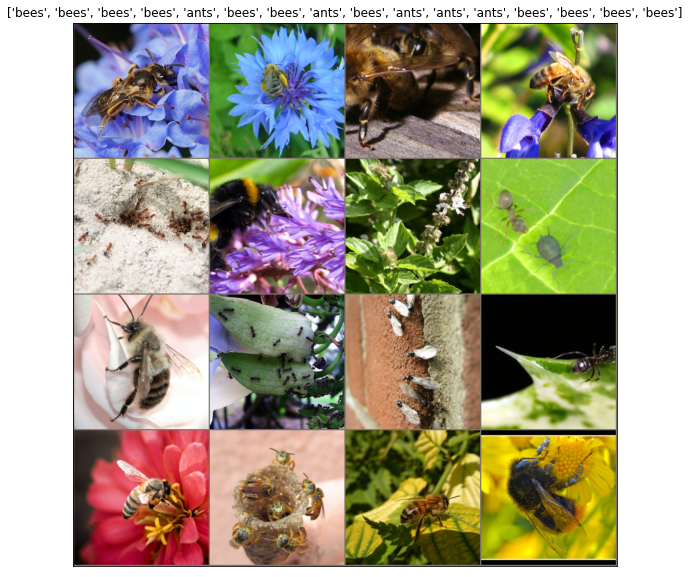

In [3]:
""" VISUALIZE IMAGES """

import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [4]:
""" MODEL TRAINING SUPPORT FUNCTION """

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [5]:
"""Test training for initial run without traning"""
def FakeTraining(model):

    for i, data in enumerate(dataloaders['val'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

    print('Finished Training')
    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
        with record_function("model_interference"):
            model(inputs)    
        
    print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
    with profile(activities=[ProfilerActivity.CPU],profile_memory=True, record_shapes=True) as prof:
        model(inputs)
    print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))
    
    """Not sure how this works but gigabrain time"""
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders['val']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the 10000 test images before any training: %.2f %%' % (
    100 * correct / total))
    

In [6]:
""" SUPPORT FUNCTION FOR VISUALIZING MODEL PREDICTIONS """
def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [7]:
""" CREATE MODEL FUNCTION """

from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [8]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [9]:
import torchvision.models.quantization as models
from torch.profiler import profile, record_function, ProfilerActivity
import torch.optim as optim

# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()



#SIZE
f=print_size_of_model(model,"ResNet fused without quantization")


#ACC
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

#model = train_model(model, criterion, optimizer, exp_lr_scheduler,
#                            num_epochs=1, device=device)
FakeTraining(model)

#TIME
"""with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_interference"):
        model(inputs)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
"""
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

model:  ResNet fused without quantization  	 Size (KB): 46837.645
Finished Training
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
               model_interference         4.52%      32.854ms        99.99%     726.800ms     726.800ms             1  
                     aten::conv2d         0.02%     167.000us        76.91%     559.003ms      27.950ms            20  
                aten::convolution         0.03%     210.000us        76.89%     558.836ms      27.942ms            20  
               aten::_convolution         0.05%     376.000us        76.86%     558.626ms      27.931ms            20  
         aten::mkldnn_convolution        76.78%     558.049ms        76.81% 

/opt/anaconda3/lib/python3.8/site-packages/torch/ao/quantization/observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [10]:
""" FINETUNING """
import torch.optim as optim

for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=5, device=device)

Epoch 0/4
----------
train Loss: 0.7544 Acc: 0.5656
val Loss: 0.3068 Acc: 0.9216

Epoch 1/4
----------
train Loss: 0.3002 Acc: 0.8893
val Loss: 0.2006 Acc: 0.9412

Epoch 2/4
----------
train Loss: 0.2366 Acc: 0.9016
val Loss: 0.1689 Acc: 0.9608

Epoch 3/4
----------
train Loss: 0.1696 Acc: 0.9549
val Loss: 0.1480 Acc: 0.9542

Epoch 4/4
----------
train Loss: 0.1003 Acc: 0.9713
val Loss: 0.1625 Acc: 0.9477

Training complete in 7m 59s
Best val Acc: 0.960784


In [11]:
""" CONVERT TO QUANTIZED MODEL """

from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

model_quantized_and_trained.eval()

#SIZE
q=print_size_of_model(model_quantized_and_trained,"ResNet fused with quantization")

#ACC
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_quantized_and_trained.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
#model_quantized_and_trained = train_model(model_quantized_and_trained, criterion, optimizer, exp_lr_scheduler,
#                             num_epochs=1, device=device)
FakeTraining(model_quantized_and_trained)


#TIME
"""
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_interference"):
        model_quantized_and_trained(inputs)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))"""

model:  ResNet fused with quantization  	 Size (KB): 11222.521
Finished Training
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
               model_interference         4.02%      15.173ms        99.99%     377.851ms     377.851ms             1  
                quantized::conv2d        46.58%     176.030ms        46.65%     176.285ms      16.026ms            11  
           quantized::conv2d_relu        45.03%     170.164ms        46.61%     176.156ms      19.573ms             9  
                 aten::contiguous         0.01%      19.000us         1.53%       5.765ms       5.765ms             1  
                      aten::clone         1.51%       5.707ms         1.52%    

'\nwith profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:\n    with record_function("model_interference"):\n        model_quantized_and_trained(inputs)\nprint(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))'

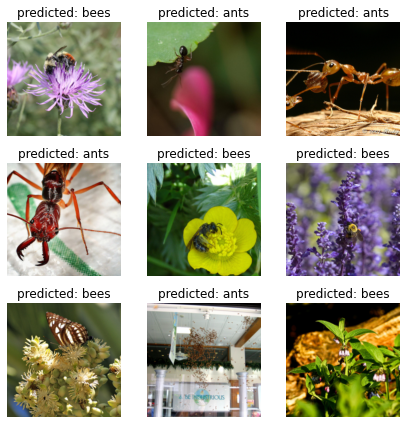

In [12]:
""" VIEW RESULT """

visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()